In [1]:
!pip install ipywidgets

In [2]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1><center><font size=8>PART A</center></font></h1>


• DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.

Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.

The data labelling is already done. Since there higher time complexity is involved in the

• DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.

• PROJECT OBJECTIVE: To build a face detection system.

### 1. Import and Understand the data

#### A. Import and read ‘images.npy’.

In [ ]:
# Load the .npy file
data = np.load('/content/drive/MyDrive/Images.npy', allow_pickle=True)
# Display some information about the loaded data
print(f"Shape of data: {data.shape}")


Shape of data: (393, 2)


In [ ]:
print(data[0][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


[[[42 37 34]
  [56 51 48]
  [71 66 63]
  ...
  [23 33 34]
  [26 36 37]
  [28 38 39]]

 [[40 35 32]
  [51 46 43]
  [64 59 56]
  ...
  [27 36 35]
  [24 33 32]
  [26 35 34]]

 [[43 38 35]
  [51 46 43]
  [61 56 53]
  ...
  [28 30 27]
  [33 35 32]
  [35 37 34]]

 ...

 [[56 47 40]
  [57 48 41]
  [61 52 45]
  ...
  [67 48 42]
  [55 35 28]
  [60 40 33]]

 [[53 44 37]
  [54 45 38]
  [57 48 41]
  ...
  [59 40 34]
  [60 40 33]
  [54 34 27]]

 [[53 44 37]
  [54 45 38]
  [57 48 41]
  ...
  [59 40 34]
  [70 50 43]
  [64 44 37]]]


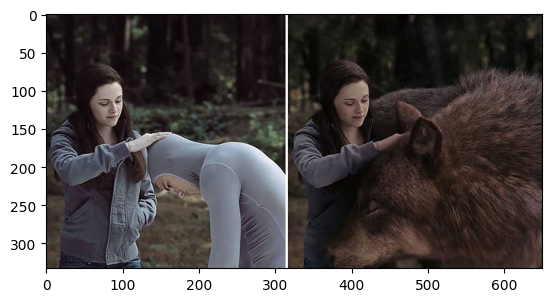

In [ ]:
import matplotlib.pyplot as plt
import cv2

print(data[0][0])
plt.imshow(data[0][0])

#### B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(masks)

print(f"Features shape (X): {X.shape}")
print(f"Labels shape (Y): {Y.shape}")

Features shape (X): (393, 224, 224, 3)
Labels shape (Y): (393, 224, 224)


#### C. Split the data into train and test (70:30 ratio).

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (275, 224, 224, 3)
Shape of X_test: (118, 224, 224, 3)
Shape of Y_train: (275, 224, 224)
Shape of Y_test: (118, 224, 224)


#### D. Select random image from the train data and display original image and masked image.


Image array: [[[-0.16862744 -0.51372552 -0.86666667]
  [-0.18431371 -0.52156866 -0.87450981]
  [-0.14509803 -0.49019605 -0.85882354]
  ...
  [ 0.18431377  0.30196083  0.11372554]
  [ 0.1686275   0.28627455  0.09019613]
  [ 0.14509809  0.27058828  0.09019613]]

 [[-0.19215685 -0.50588238 -0.89019608]
  [-0.1607843  -0.49019605 -0.88235295]
  [-0.17647058 -0.52156866 -0.87450981]
  ...
  [-0.03529412 -0.05098039 -0.15294117]
  [-0.05882353 -0.09019607 -0.17647058]
  [-0.05098039 -0.09803921 -0.19215685]]

 [[-0.2235294  -0.50588238 -0.89803922]
  [-0.15294117 -0.48235291 -0.85882354]
  [-0.17647058 -0.50588238 -0.87450981]
  ...
  [-0.04313725 -0.0745098  -0.1607843 ]
  [-0.05882353 -0.11372548 -0.19215685]
  [-0.05098039 -0.10588235 -0.18431371]]

 ...

 [[-0.92156863 -0.88235295 -0.93725491]
  [-0.87450981 -0.85882354 -0.93725491]
  [-0.79607844 -0.83529413 -0.92156863]
  ...
  [-0.66274512 -0.66274512 -0.69411767]
  [-0.70980394 -0.70980394 -0.72549021]
  [-0.64705884 -0.59215689 -0.6

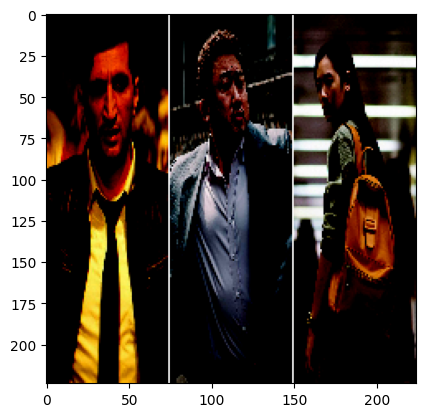

In [ ]:
# original image
n = 5
print("Image array:", X_train[5])
plt.imshow(X_train[5])

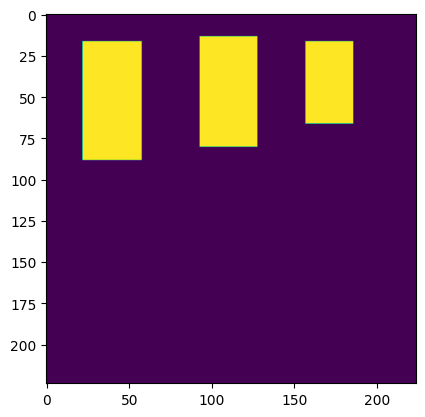

In [ ]:
#masked image

plt.imshow(Y_train[n])

### 2. Model building

#### A. Design a face mask detection model.

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [ ]:
model = create_model()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 32)   │            128 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1                 │ (None, 112, 112, 32)   │            288 │ conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_bn              │ (None, 112, 112, 32)   │            128 │ conv_dw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_relu (ReLU)     │ (None, 112, 112, 32)   │              0 │ conv_dw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1 (Conv2D)        │ (None, 112, 112, 64)   │          2,048 │ conv_dw_1_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_bn              │ (None, 112, 112, 64)   │            256 │ conv_pw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_relu (ReLU)     │ (None, 112, 112, 64)   │              0 │ conv_pw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pad_2                │ (None, 113, 113, 64)   │              0 │ conv_pw_1_relu[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2                 │ (None, 56, 56, 64)     │            576 │ conv_pad_2[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_bn              │ (None, 56, 56, 64)     │            256 │ conv_dw_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_relu (ReLU)     │ (None, 56, 56, 64)     │              0 │ conv_dw_2_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2 (Conv2D)        │ (None, 56, 56, 128)    │          8,192 │ conv_dw_2_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2_bn              │ (None, 56, 56, 128)    │            512 │ conv_pw_2[0][0]        │
│ (BatchNormalization) 

 Total params: 3,230,849 (12.32 MB)

 Trainable params: 3,208,961 (12.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

#### B. Design your own Dice Coefficient and Loss function.

In [ ]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Compile the model with custom loss function
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient])


#### C. Train and tune the model as required.

In [ ]:
# Define the filepath with .weights.h5 extension
filepath = "model-{loss:.2f}.weights.h5"

checkpoint = ModelCheckpoint(filepath, monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
model.fit(X_train, Y_train, epochs=10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/10
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - dice_coefficient: 0.3825 - loss: 0.6175
Epoch 1: loss improved from inf to 0.56019, saving model to model-0.56.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - dice_coefficient: 0.3829 - loss: 0.6171 - learning_rate: 0.0010
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - dice_coefficient: 0.5627 - loss: 0.4373
Epoch 2: loss improved from 0.56019 to 0.43023, saving model to model-0.43.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - dice_coefficient: 0.5627 - loss: 0.4373 - learning_rate: 0.0010
Epoch 3/10
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - dice_coefficient: 0.6165 - loss: 0.3835
Epoch 3: loss improved from 0.43023 to 0.40616, saving model to model-0.41.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - dice_coefficient: 0.6164 - loss: 0.3836 - learning_rate: 0.0010
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coefficient: 0.6114 - loss: 0.3886
Epoch 4: loss improved from 0.40616 to 

#### D. Evaluate and share insights on performance of the model.


#### 3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

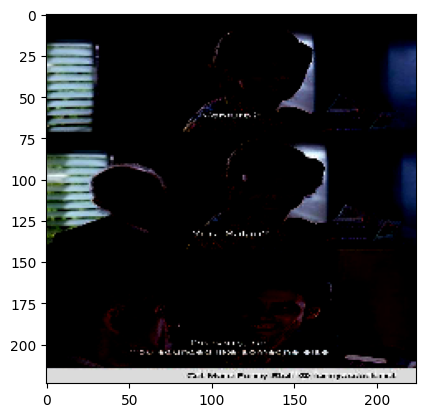

In [ ]:
m = 3
plt.imshow(X_test[m])

In [ ]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[m]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


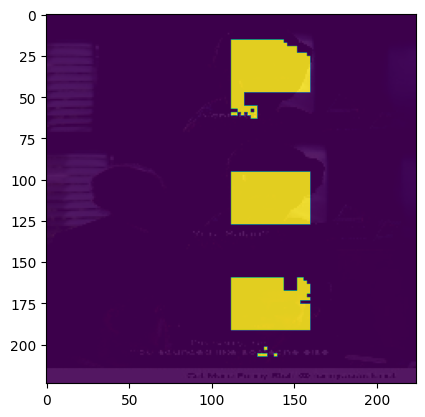

In [ ]:
plt.imshow(X_test[m])
plt.imshow(pred_mask, alpha=0.9)

<h1><center><font size=8>PART B</center></font></h1>


• DOMAIN: Entertainment
• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene.

The data labelling is already done. Since there higher time complexity is involved in the

• DATA DESCRIPTION: The dataset comprises of face images.

• PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

1. Read/import images from folder ‘training_images’.

In [ ]:
import cv2
import os
import glob
img_dir = "/content/drive/MyDrive/training_images/" # Enter Directory of all images
data_path = os.path.join(img_dir,'*g') # '*' is used to extract all files in the directory
files = glob.glob(data_path)

In [ ]:
data = []  # EMPTY LIST
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)

In [ ]:
len(data)

1088

In [ ]:
dir_list = next(os.walk(img_dir))[2]
dir_list

['real_00089.jpg',
 'real_00090.jpg',
 'real_00091.jpg',
 'real_00092.jpg',
 'real_00093.jpg',
 'real_00094.jpg',
 'real_00095.jpg',
 'real_00096.jpg',
 'real_00097.jpg',
 'real_00098.jpg',
 'real_00099.jpg',
 'real_00100.jpg',
 'real_00102.jpg',
 'real_00101.jpg',
 'real_00104.jpg',
 'real_00105.jpg',
 'real_00106.jpg',
 'real_00107.jpg',
 'real_00103.jpg',
 'real_00108.jpg',
 'real_00109.jpg',
 'real_00110.jpg',
 'real_00111.jpg',
 'real_00112.jpg',
 'real_00113.jpg',
 'real_00114.jpg',
 'real_00115.jpg',
 'real_00116.jpg',
 'real_00117.jpg',
 'real_00118.jpg',
 'real_00119.jpg',
 'real_00122.jpg',
 'real_00120.jpg',
 'real_00121.jpg',
 'real_00123.jpg',
 'real_00124.jpg',
 'real_00127.jpg',
 'real_00126.jpg',
 'real_00125.jpg',
 'real_00128.jpg',
 'real_00129.jpg',
 'real_00130.jpg',
 'real_00131.jpg',
 'real_00132.jpg',
 'real_00133.jpg',
 'real_00134.jpg',
 'real_00136.jpg',
 'real_00135.jpg',
 'real_00137.jpg',
 'real_00138.jpg',
 'real_00139.jpg',
 'real_00141.jpg',
 'real_00140

2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.

In [ ]:
x_cord=[]
y_cord=[]
height=[]
width=[]
face_detected=[]
image_name=[]# Open cv version 2

import cv2

face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/haarcascade_frontalface_default.xml")   # frontal face

# Check if the cascade classifier was loaded correctly
if face_cascade.empty():
  print("Error loading cascade classifier")
else:
  for i in range (len(dir_list)):
      print("Execution loop=",i)
      data_path = os.path.join(img_dir,dir_list[i])
      img=cv2.imread(data_path)
      faces=face_cascade.detectMultiScale(img,scaleFactor=1.05,minNeighbors=5)

      j=0

      # Find coordinates of the face
      for x,y,w,h in faces:
          img=cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 0),2)
          j=j+1
      resized=cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0])))

      length=len(faces)
      if length==0:
          a=0
          b=0
          c=0
          d=0
          j=0
          name=0

      else:
          a=faces[0,0]
          b=faces[0,1]
          c=faces[0,2]
          d=faces[0,3]
          name=dir_list[i]


      x_cord.append(a)
      y_cord.append(b)
      width.append(c)
      height.append(d)
      face_detected.append(j)
      image_name.append(name)

Execution loop= 0
Execution loop= 1
Execution loop= 2
Execution loop= 3
Execution loop= 4
Execution loop= 5
Execution loop= 6
Execution loop= 7
Execution loop= 8
Execution loop= 9
Execution loop= 10
Execution loop= 11
Execution loop= 12
Execution loop= 13
Execution loop= 14
Execution loop= 15
Execution loop= 16
Execution loop= 17
Execution loop= 18
Execution loop= 19
Execution loop= 20
Execution loop= 21
Execution loop= 22
Execution loop= 23
Execution loop= 24
Execution loop= 25
Execution loop= 26
Execution loop= 27
Execution loop= 28
Execution loop= 29
Execution loop= 30
Execution loop= 31
Execution loop= 32
Execution loop= 33
Execution loop= 34
Execution loop= 35
Execution loop= 36
Execution loop= 37
Execution loop= 38
Execution loop= 39
Execution loop= 40
Execution loop= 41
Execution loop= 42
Execution loop= 43
Execution loop= 44
Execution loop= 45
Execution loop= 46
Execution loop= 47
Execution loop= 48
Execution loop= 49
Execution loop= 50
Execution loop= 51
Execution loop= 52
Exe

3. From the same loop above, extract metadata of the faces and write into a DataFrame.

In [ ]:
import pandas as pd

df = pd.DataFrame(x_cord, columns = ['x'])

df['y']=y_cord
df['w']=width
df['h']=height
df['Total_Faces']=face_detected
df['Image_Name']=image_name

df.head()

,x,y,w,h,Total_Faces,Image_Name
0,89,180,411,411,1,real_00089.jpg
1,70,75,490,490,1,real_00090.jpg
2,34,97,471,471,1,real_00091.jpg
3,46,186,393,393,1,real_00092.jpg
4,117,161,423,423,1,real_00093.jpg


4. Save the output Dataframe in .csv format.

In [ ]:
df.to_excel("Bounding boxes.xlsx")
df.to_csv("Bounding boxes.csv")
df.to_json("Bounding boxes.json")

<h1><center><font size=8>PART C</center></font></h1>


• DOMAIN: Face Recognition

• CONTEXT: Company X intends to build a face identification model to recognise human faces.

• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people.
All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:

1. Unzip, read and Load data(‘PINS.zip’) into session.

In [3]:
import tensorflow
tensorflow.__version__

'2.17.0'

In [5]:
import shutil
import os

# Delete an entire directory
directory_to_delete = '/content/drive/MyDrive/PINS_dataset/'  # Replace with your directory path
if os.path.exists(directory_to_delete):
    shutil.rmtree(directory_to_delete)
    print(f"Directory {directory_to_delete} has been deleted.")
else:
    print("The directory does not exist.")


Directory /content/drive/MyDrive/PINS_dataset/ has been deleted.


In [6]:
# Unzipping the PINS.zip file into the session
from zipfile import ZipFile

zip_file_path = '/content/drive/MyDrive/PINS.zip'
image_path = '/content/drive/MyDrive/PINS_dataset/'

# Unzipping the file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(image_path)

print("Data extracted successfully to:", image_path)


Data extracted successfully to: /content/drive/MyDrive/PINS_dataset/


2. Write function to create metadata of the image.

In [7]:
import numpy as np
import cv2
import os

class IdentityMetadata():
    def __init__(self, base, name, file):

        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('/content/drive/MyDrive/PINS_dataset/PINS')

3. Write a loop to iterate through each and every image and create metadata for all the images.

In [8]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

array([[[233, 188, 165],
        [231, 186, 163],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[232, 187, 164],
        [233, 188, 165],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[230, 186, 161],
        [228, 184, 159],
        [206, 164, 140],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       ...,

       [[198, 118,  91],
        [197, 120,  94],
        [195, 119,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[200, 120,  93],
        [200, 120,  93],
        [198, 121,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[201, 121,  94],
        [201, 121,  94],
        [199, 122,  96],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]]], dtype=uint8)
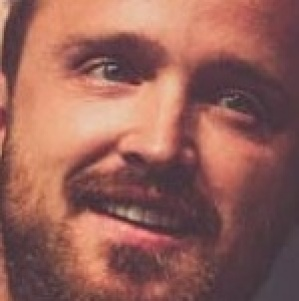

In [9]:
# Loading an image
load_image(metadata[0].image_path())

4. Generate Embeddings vectors on the each face in the dataset.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [11]:
from tensorflow.keras.models import model_from_json
model = vgg_face()
model.load_weights('/content/drive/MyDrive/vgg_face_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [13]:
# Getting the embedding vector for the first image in the metadata using the pre-trained VGGFace model

img_path = metadata[0].image_path()

img = load_image(img_path)

# This converts RGB values to a floating-point scale between [0, 1] for the model input
img = (img / 255.0).astype(np.float32)

img = cv2.resize(img, (224, 224))

# This confirms the image is ready to be fed into the VGGFace model
print("Image shape after resizing:", img.shape)

# The model expects input in the format (batch_size, height, width, channels), so we add an extra dimension
img = np.expand_dims(img, axis=0)

# Assuming `vgg_face_descriptor` is your loaded VGGFace model
embedding_vector = vgg_face_descriptor.predict(img)[0]

# This should typically be a 1D vector with a length of 2622 (for the original VGGFace model)
print("Embedding vector shape:", embedding_vector.shape)


Image shape after resizing: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Embedding vector shape: (2622,)


In [14]:
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

# Function to process each image
def process_image(meta):
    try:
        image = load_image(str(meta))
        image = (image / 255.).astype(np.float32)
        image = cv2.resize(image, (224, 224))
        return vgg_face_descriptor.predict(np.expand_dims(image, axis=0))[0]
    except:
        return np.zeros(2622)

# Parallel processing for embeddings extraction
def extract_embeddings(metadata, num_workers=4):
    embeddings = np.zeros((metadata.shape[0], 2622))

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, meta) for meta in metadata]

        for i, future in enumerate(tqdm(futures, desc="Extracting embeddings", total=len(futures))):
            embeddings[i] = future.result()

    return embeddings

embeddings = extract_embeddings(metadata, num_workers=os.cpu_count())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


Extracting embeddings:   0%|          | 0/10770 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

5. Build distance metrics for identifying the distance between two similar and dissimilar images.

In [15]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

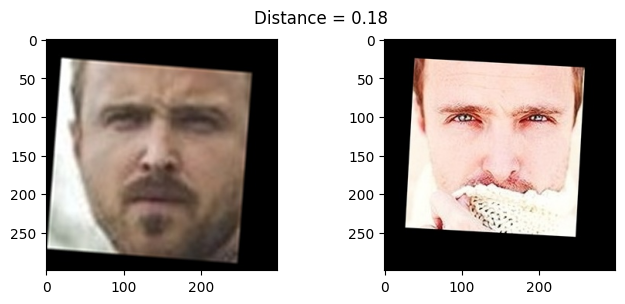

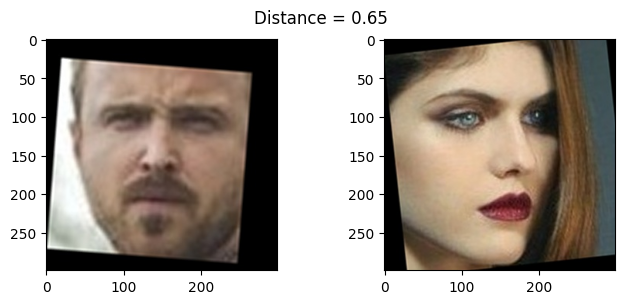

In [16]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

show_pair(4, 3)
show_pair(4, 90)

In [17]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [19]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

6. Use PCA for dimensionality reduction.

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

7. Build an SVM classifier in order to map each image to its right person.

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with different hyperparameters
clf = SVC(kernel='linear', C=1, gamma='scale', class_weight='balanced')

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the classifier: {accuracy * 100:.2f}%")


Accuracy of the classifier: 95.32%


8. Import and display the the test images.

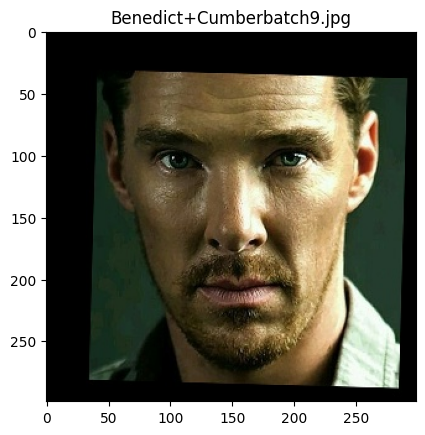

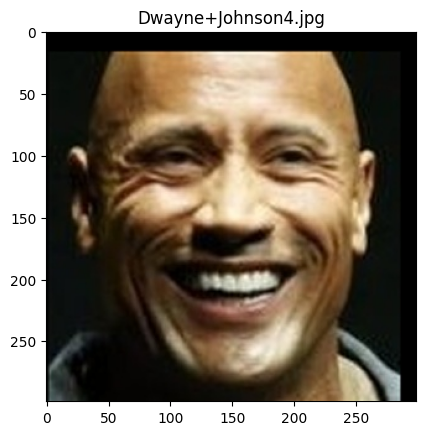

In [22]:
import matplotlib.pyplot as plt

def load_and_display_image(image_path):
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(image_path))
    plt.show()

# Test function with one of the test images
test_image1 = '/content/drive/MyDrive/Benedict+Cumberbatch9.jpg'
test_image2='/content/drive/MyDrive/Dwayne+Johnson4.jpg'
load_and_display_image(test_image1)
load_and_display_image(test_image2)



Use the trained SVM model to predict the face on both test images.

In [23]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = clf.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = encoder.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


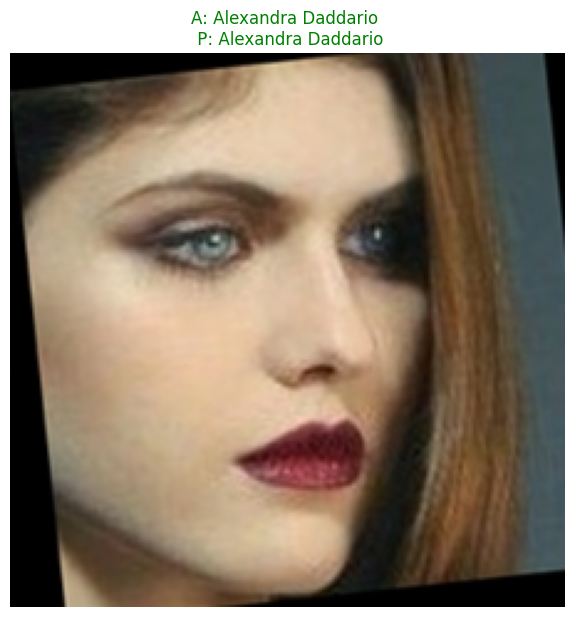

In [ ]:
# Plot for 10th image in test data
sample_img, actual_name, pred_name = sample_img_plot(10)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Shape of embedding: (2622,)
Shape of embedding_scaled: (1, 2622)


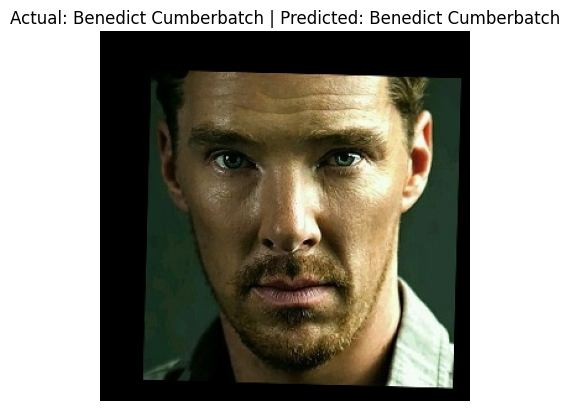

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Shape of embedding: (2622,)
Shape of embedding_scaled: (1, 2622)


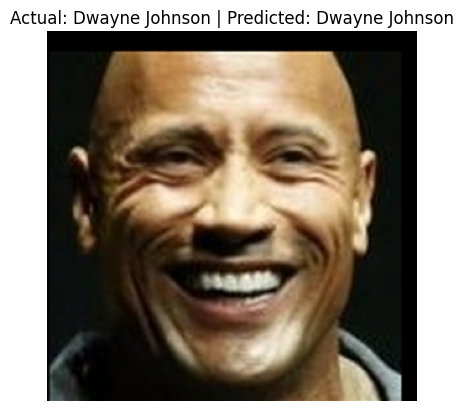

In [37]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import re

# Paths to the test images
test_image1 = '/content/drive/MyDrive/Benedict+Cumberbatch9.jpg'
test_image2 = '/content/drive/MyDrive/Dwayne+Johnson4.jpg'
test_images = [test_image1, test_image2]

def load_mage(image_path):
    img = cv2.imread(image_path)
    return img # Return the image

def sample_img_plot(image_path):
    # Load the test image using the provided image_path
    sample_img = load_mage(image_path)

    # Extract the actual name from the file name (e.g., 'Benedict+Cumberbatch9.jpg')
    actual_name = os.path.basename(image_path).split('.')[0]

# Replace '+' with spaces, remove digits, title-case the name, and strip spaces
    actual_name = re.sub(r'[0-9]', '', actual_name).replace('+', ' ').title().strip()

    # Normalize pixel values
    sample_img = (sample_img / 255.).astype(np.float32)

    # Resize to the required input size for the model
    sample_img = cv2.resize(sample_img, (224, 224))

    # Obtain embedding vector for the sample image
    embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis=0))[0]

    # Check the shape of the embedding vector
    print("Shape of embedding:", embedding.shape)

    # Scale the embedding vector
    embedding_scaled = sc.transform(embedding.reshape(1, -1))

    # Check the shape of embedding_scaled
    print("Shape of embedding_scaled:", embedding_scaled.shape)

    # Apply PCA transformation to the scaled embedding
    embedding_pca = pca.transform(embedding_scaled)

    # Predict the identity using the trained SVM classifier (clf)
    sample_pred = clf.predict(embedding_pca)

    # Transform the predicted label back to the name
    pred_name = encoder.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()

    # Display the test image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib display
    plt.imshow(img_rgb)
    plt.title(f"Actual: {actual_name} | Predicted: {pred_name}")
    plt.axis('off')
    plt.show()

# Predict and display the faces for both test images
for image_path in test_images:
    sample_img_plot(image_path)